In [1]:
%matplotlib inline
import json
import dateutil.parser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys, os
import boto3

sys.path.append('.\\app\\util')
from FantasyFootballOffense import calc_past_offensive_fantasy_values

statDict = dict()
seasonsList = list()

#1. Get the game stats for each TE for every year they have played
s3 = boto3.resource('s3')
try:
    gamesObj = s3.Object('fantasyfootballdata', 'games_TE_train.json')
    gamesDf = pd.read_json(gamesObj.get()['Body'].read().decode('utf-8'))
    gamesDf.sort_values(by=['player_id'])

except botocore.exceptions.ClientError as e:
    # If a client error is thrown, then check that it was a 404 error.
    # If it was a 404 error, then the bucket does not exist.
    error_code = int(e.response['Error']['Code'])
    print(error_code)

#2. Loop through TE player_id's and calculate fantasy values
#3. Record the number of seasons played for lifespan study of the TE position
for player_id in gamesDf.player_id.unique():
    career = gamesDf.loc[gamesDf.player_id == player_id]
    if career is not None and len(career) > 0:
        seasons = calc_past_offensive_fantasy_values(career)
        if(len(seasons) > 0):
            statDict[player_id] = seasons
            seasonsList.append(len(seasons))

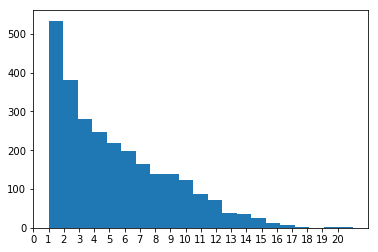

In [12]:
#4. Perform lifespan study for the TE position; then comment this out.
plt.hist(seasonsList, bins=21)
plt.xticks(np.arange(0, 21, step=1))
plt.show()

#5. Calculate the prime age curve for the WR position
#teStatDfNoFill = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in teStatDict.items()]))
#teStatDfWithFill = teStatDfNoFill.fillna(0)
#teStatDfWithFill['averageWithFill'] = teStatDfWithFill.mean(axis=1)
#teStatDfWithFill['averageNoFill'] = teStatDfNoFill.mean(axis=1)
#teStatDfWithFill['averageOverall'] = (tesStatDfWithFill['averageWithFill'] + teStatDfWithFill['averageNoFill']) / 2
#teStatDfWithFill.to_csv("C:\\Users\\kjree\\Workspaces\\ml-fantasy-football-model\\te_fantasy_values.csv", index=False, encoding='utf8')
#p7 = np.poly1d(np.polyfit(teStatDfWithFill.index, teStatDfWithFill['averageOverall'], 7))
#xp = np.linspace(0,27,100)
#plt.scatter(teStatDfWithFill.index, teStatDfWithFill['averageOverall'])
#plt.plot(xp, p7(xp), c='r')
#plt.show()

#6. Aspect B of the NFL Player Model:
# Group all TE's into top 0-20%,21-40%,41-60%,61-80%, and 81-100% based on last year's fantasy values
#teLastYearStatDict = dict()
#for key in teCareerDict.keys():
#    career = teCareerDict[key]
#    if career is not None and len(career) > 0:
#        lastYear = calcPastFantasyPointValue(career, 2017)
#        if lastYear is not None:
#            teLastYearStatDict[key] = lastYear